# Walmart Sales Forecast
This notebook explores the sales data of 45 Wal-Mart locations. Exploritory data analysis was perfomed at the store and deparment level and the finding were used to forecast the sales.

    Functionality Setting

In [1]:
import warnings
warnings.filterwarnings("ignore")

    Dependencies

In [244]:
import matplotlib.pyplot as plt
#%matplotlib inline

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

import seaborn as sns
import pandas as pd
import numpy as np
import datetime

# 1. Data Imports and Manipulation
The sales and store data was collected from [Walmart Recruiting's Kaggle Competition](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting). This dataset only includes the influence of 4 holidays. Entering this project with the assumption that consumer spending is heavily influenced by holidays so a [second source](https://www.timeanddate.com/holidays/us/2010?hol=17) was utilized to collect all relevant consumer events and commonly observed U.S. holidays. The datasets were then consolidated in a [separate script](https://github.com/octaviaisom/Walmart-Sales-Forecast/blob/master/holidates.py) (due to its extended runtime) and saved in ``` sales_updated.csv ```.

In [29]:
csv = pd.read_csv("data/holidays.csv")
holidays = pd.DataFrame(csv)

holidays.head()

,Holiday,Date
0,Black Friday,2010-11-26
1,Black Friday,2011-11-25
2,Black Friday,2012-11-23
3,Black Friday,2013-11-29
4,Christmas Day,2010-12-25


In [30]:
holidays.Date = pd.to_datetime(holidays.Date)

In [59]:
#walmart's
csv = pd.read_csv("data/sales.csv")
sales = pd.DataFrame(csv)

sales.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [60]:
sales.Date = pd.to_datetime(sales.Date)

In [7]:
#all
csv = pd.read_csv("data/sales_updated.csv")
sales_all = pd.DataFrame(csv)

sales_all.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,9/28/2012,508.37,False
421566,45,98,10/5/2012,628.10,False
421567,45,98,10/12/2012,1061.02,False
421568,45,98,10/19/2012,760.01,False
421569,45,98,10/26/2012,1076.80,False


In [8]:
sales_all.Date = pd.to_datetime(sales.Date)

In [9]:
sales.info()
sales.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [10]:
csv = pd.read_csv("data/stores.csv")
stores = pd.DataFrame(csv)

stores.tail()

,Store,Type,Size
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


In [11]:
stores.info()
stores.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


# 2. EDA

In [246]:
#setting color pallete for charts
pio.templates.default = "plotly_white"
palette = flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(palette)

plt.style.use('seaborn-darkgrid')


## Record Counts
Review missing values

In [13]:
sales.nunique()

Store               45
Dept                81
Date               143
Weekly_Sales    359464
IsHoliday            2
dtype: int64

In [14]:
45*81*143 == len(sales)

False

In [15]:
#Departments with missing weekly sales
sales.groupby('Dept').nunique().query("Date<143")

,Store,Dept,Date,Weekly_Sales,IsHoliday
Dept,,,,,
39,5,1,16,12,2
43,5,1,12,6,2
47,37,1,138,277,2
51,37,1,131,780,2
77,37,1,35,58,2
78,37,1,82,38,2
99,37,1,94,311,2


In [16]:
#Stores with missing weekly sales
sales.groupby('Store').nunique().query("Date<143")

,Store,Dept,Date,Weekly_Sales,IsHoliday
Store,,,,,


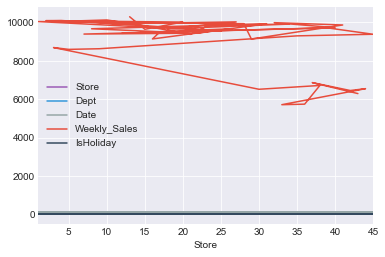

In [17]:
#Number of unique depts per store
sales.groupby('Store').nunique().sort_values(['Dept']).plot()

## Sales Analysis
High-level analysis of sales and holiday's potential influence on seasonality

In [368]:
byDate = sales.groupby('Date',sort=False).sum()
byDate.IsHoliday = byDate.IsHoliday.astype('bool').astype('int')
#byDate.index.freq = 'W-FRI'
byDate.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,65124,130557,49750740.50,0
2010-02-12,65082,131179,48336677.63,1
2010-02-19,65610,131897,48276993.78,0
2010-02-26,65045,130161,43968571.13,0
2010-03-05,64897,129670,46871470.30,0


In [389]:
holidaysdf = byDate.query("IsHoliday==1")

In [410]:
# Total weekly sales
final_wk = byDate.index.max()
ymin=byDate.index.min()
ymax=byDate.index.max()

lin = go.Figure(data=go.Scatter(x=byDate.index, y=byDate.Weekly_Sales, name="Weekly Sales"))

bar_size = [.8]*len(holidaysdf.index)
lin.add_trace(
    go.Bar(
        x=holidaysdf.index,
        y=holidaysdf.Weekly_Sales,
        name= 'Holidays',
        opacity=0.1,
        width = 5
    ))





lin.show()


Day-of and trailing/leading

# Sales by Store
How does the stores' size/type influences sales?

In [77]:
byStore = sales.reset_index().groupby('Store', as_index=False).sum()
byStore = pd.merge(byStore, stores, on='Store', how='left')
byStore.head()

,Store,index,Dept,Weekly_Sales,IsHoliday,Type,Size
32,33,2058266717,302780,37160221.96,453.0,A,39690
43,44,2927446812,335081,43293087.84,499.0,C,39910
4,5,398556711,371526,45475688.90,640.0,B,34875
35,36,2136619245,293473,53412214.97,437.0,A,39910
37,38,2631145671,340471,55159626.42,510.0,C,39690


In [73]:
byStore.nunique()

Store           45
index           45
Dept            45
Weekly_Sales    45
IsHoliday       35
Type             3
Size            40
dtype: int64

In [78]:
#Formatting df for visuals
byStore = byStore[["Store", "Weekly_Sales", "Type", "Size"]]
byStore.head()

,Store,Weekly_Sales,Type,Size
32,33,37160221.96,A,39690
43,44,43293087.84,C,39910
4,5,45475688.90,B,34875
35,36,53412214.97,A,39910
37,38,55159626.42,C,39690


In [248]:
byStore_Bar = go.Figure(data=go.Bar(x=byStore.Store,
                                y=byStore.Weekly_Sales, 
                                name='Weekly_Sales')
)



byStore_Bar.update_layout(title={
        'text': "Total Weekly Sales with All Holiday Markers",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

byStore_Bar.show()


SOME STORE THAT OUTPERFORM OTHERS...POTENTIALLY INFLUENCED BY Type SIZE LOCATION ETC...

In [249]:
fig = px.box(byStore, x="Type", y="Weekly_Sales", color="Type")

fig.show()

In [250]:
fig = px.box(byStore, x="Type", y="Size", color="Type")

fig.show()

In [251]:
size_Dist = px.histogram(byStore, x="Size", color='Type')

size_Dist.show()

In [252]:
fig = px.scatter(byStore, x="Size",y='Weekly_Sales',color='Type')

fig.show()

In [253]:
byStore['SalesPerSF'] = byStore.Weekly_Sales/byStore.Size

fig = px.scatter(byStore, x="Size",y='SalesPerSF',color='Type')

fig.show()

types seem to be based soley on size....smaller store making best use of space...larger store appear to be average ....medium have lowest performance

...type influenced by size...bc previous does not provided the desired detail...dig deeper into size..cluster to further analyze the sales behavior across stores SIZES...

Cluster Stores
in hope to find stronger relationships...use ml to cluter store based on size

In [280]:
byStorex = byStore[['SalesPerSF','Weekly_Sales', 'Size']]
byStorex.head()

,SalesPerSF,Weekly_Sales,Size
32,936.261576,37160221.96,39690
43,1084.767924,43293087.84,39910
4,1303.962406,45475688.90,34875
35,1338.316587,53412214.97,39910
37,1389.761311,55159626.42,39690


In [281]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6) 
kmeans.fit(byStorex)
byStorex['Cluster'] = kmeans.labels_
byStorex.head()

,SalesPerSF,Weekly_Sales,Size,Cluster
32,936.261576,37160221.96,39690,3
43,1084.767924,43293087.84,39910,3
4,1303.962406,45475688.90,34875,3
35,1338.316587,53412214.97,39910,3
37,1389.761311,55159626.42,39690,3


NOW THAT THE STORE ARE CLUSTERED...MORE MEANINGFUL inferences...size's influence on sales

In [283]:
fig = px.scatter(byStorex, x="Size",y='SalesPerSF',color='Cluster', size='Weekly_Sales')

fig.show()

In [260]:
fig = px.box(byStorex, x="Cluster", y="SalesPerSF", color="Cluster")

fig.show()

FINAL STORE SALES THOUGHTS...

# Sales by Dept
Which departments are influenced by seasonality?

In [34]:
#number of unique departments
sales['Dept'].nunique()

81

In [285]:
byDept = sales.groupby(['Dept']).sum()
byDept.head()

,Store,Weekly_Sales,IsHoliday
Dept,,,
1,148005,1.236388e+08,450.0
2,148005,2.806112e+08,450.0
3,148005,7.589245e+07,450.0
4,148005,1.671467e+08,450.0
5,144441,1.356074e+08,443.0


In [289]:
byDept_Bar = px.bar(byDept, y='Weekly_Sales')


byDept_Bar.show()


as expected prices vary very heavily among depts...negative sales (loss) observed...filter store with negative sales

In [36]:
byDept.query('Weekly_Sales<=0')

,Store,Weekly_Sales,IsHoliday
Dept,,,
47,12641,-4962.93,55.0


## DICKEY-FULLER TEST
determine stationarity...lags!!

In [318]:
from statsmodels.tsa.stattools import adfuller

In [319]:
#salesx = pd.read_csv("data/sales.csv")
#salesx.head()

In [320]:
#median number of records for depts with NO missing week
sales.groupby('Dept').nunique().sort_values('Date').query('Date==143')['Weekly_Sales'].median()

5873.0

In [321]:
sales.Date.nunique()

143

In [322]:
#Depts with missing weeks
dept_w_missing_wks = sales.groupby('Dept').nunique().sort_values('Date').query('Date<143')
missing_wks = dept_w_missing_wks.index

In [323]:
for dept in missing_wks:
    data = sales.query(f"Dept=={dept}").groupby('Date').sum()
    fig = px.line(data, y="Weekly_Sales")
    fig.show()

In [337]:
stat_list = []
stat_bool_list = []
dept_list = []
depts = sales.Dept.unique()
for dept in depts:
    if dept in missing_wks:
        continue
        
    byDeptx = sales.query(f"Dept=={dept}").groupby('Date').sum()
    dftest = adfuller(byDeptx['Weekly_Sales'], maxlag=55)
    p_value = dftest[1]
    lags = dftest[2]

    if p_value <= 0.05:
        stationarity = "Stationary"
        station_bool = 1
        
    else:
        stationarity = "Non-Stationary"
        station_bool = 0
    
    dept_list.append(dept)
    stat_list.append(stationarity)
    stat_bool_list.append(station_bool)

stationarities = pd.DataFrame({'Dept': dept_list,
                              'Stationary': stat_list,
                              'Stationary_Bool': stat_bool_list})
stationarities.head()

,Dept,Stationary,Stationary_Bool
0,1,Stationary,1
1,2,Non-Stationary,0
2,3,Non-Stationary,0
3,4,Non-Stationary,0
4,5,Non-Stationary,0


STATIONARY VS NON-STATIONARY...COUNT, %OF DEPT, %OF SALES DEPEND ON SEASONALITY/TRENDS??

In [338]:
byStat = pd.merge(sales, stationarities, on='Dept', how='left')
byStat = byStat.groupby(['Stationary','Date'], as_index=False).sum()

byStat.head()

,Stationary,Date,Store,Dept,Weekly_Sales,IsHoliday,Stationary_Bool
0,Non-Stationary,2010-02-05,58915,122060,48039569.65,0.0,0.0
1,Non-Stationary,2010-02-12,58777,122443,46032611.95,2658.0,0.0
2,Non-Stationary,2010-02-19,59111,122932,46248198.63,0.0,0.0
3,Non-Stationary,2010-02-26,58787,121808,42400522.75,0.0,0.0
4,Non-Stationary,2010-03-05,58709,121288,45083785.01,0.0,0.0


In [343]:
byStat_line = px.line(byStat,x='Date', y='Weekly_Sales', color='Stationary')
byStat_line.show()

In [344]:
fig = px.pie(byStat, values='Weekly_Sales', names='Stationary')
fig.show()

# 3. Forecasting
describe methodology..stationarity/DFT results determine model type(ARIMA or SARIMAx)...Eget felis eget nunc lobortis mattis. Vulputate sapien nec sagittis aliquam malesuada bibendum. Adipiscing tristique risus nec feugiat in fermentum posuere urna. Sapien pellentesque habitant morbi tristique senectus et netus. Faucibus scelerisque eleifend donec pretium vulputate sapien nec. Eget egestas purus viverra

## Seasonal Decomposition

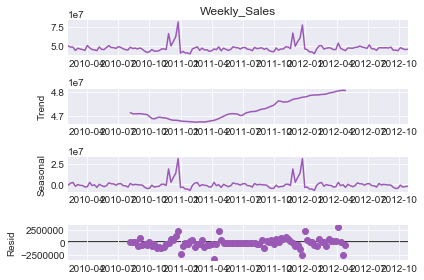

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(byDate['Weekly_Sales'], model='add')
result.plot();

# SARIMA

In [345]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima    

In [346]:
byDate.IsHoliday = byDate.IsHoliday.astype('bool').astype('int')
byDate.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,65124,130557,49750740.50,0
2010-02-12,65082,131179,48336677.63,1
2010-02-19,65610,131897,48276993.78,0
2010-02-26,65045,130161,43968571.13,0
2010-03-05,64897,129670,46871470.30,0


In [347]:
byDate.index.freq = 'W-FRI'
byDate.index

DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', name='Date', length=143, freq='W-FRI')

In [348]:
#confirm stationarity
adfuller(byDate['Weekly_Sales'], maxlag=55)

(0.5483968487251434,
 0.9862721701632599,
 52,
 90,
 {'1%': -3.505190196159122,
  '5%': -2.894232085048011,
  '10%': -2.5842101234567902},
 2791.5185459500194)

In [349]:
#Run pmdarima.auto_arima to obtain recommended orders
auto_arima(byDate['Weekly_Sales'],seasonal=True,m=52).summary()

C:\Users\octav\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\octav\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\octav\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  143
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -2376.907
Date:                             Sat, 23 May 2020   AIC                           4767.813
Time:                                     17:41:10   BIC                           4788.553
Sample:                                          0   HQIC                          4776.241
                                             - 143                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.103e+07   1.59e-08   1.95e+15      0.000     3.1e+07     3.1e+07
ar.L1         -0.8263      0.277     -2.982      0.003      -1.370      -0.283
ar.L2         -0.1655      0.411     -0.403      0.687      -0.971       0.640
ma.L1          1.2206      0.284      4.303      0.000       0.665       1.777
ma.L2          0.6215      0.272      2.282      0.022       0.088       1.155
ar.S.L52       0.6713      0.041     16.271      0.000       0.590       0.752
sigma2      2.389e+13   1.82e-14   1.31e+27      0.000    2.39e+13    2.39e+13
===================================================================================
Ljung-Box (Q):                       24.98   Jarque-Bera (JB):               891.56
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.28e+43. Standard errors may be unstable.
"""

In [351]:
#Split the data into train/test setsdates = byDate.index
length = len(byDate)
train_len = int(length*0.70)

train = byDate.iloc[:train_len]
test = byDate.iloc[train_len:]

In [57]:
#Fit a SARIMA(1,0,0)(2,0,0,7) Model
model = SARIMAX(train['Weekly_Sales'],order=(2,0,2),seasonal_order=(1,0,0,52),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Weekly_Sales   No. Observations:                   71
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -1207.538
Date:                             Sat, 23 May 2020   AIC                           2427.076
Time:                                     09:42:28   BIC                           2440.653
Sample:                                 02-05-2010   HQIC                          2432.475
                                      - 06-10-2011                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0945      0.643      0.147      0.883      -1.166       1.355
ar.L2          0.8967      0.649      1.381      0.167      -0.376       2.170
ma.L1          0.3016      0.675      0.447      0.655      -1.022       1.625
ma.L2         -0.4643      0.470     -0.987      0.324      -1.386       0.458
ar.S.L52       0.4789      0.094      5.122      0.000       0.296       0.662
sigma2      3.385e+13   2.12e-15    1.6e+28      0.000    3.39e+13    3.39e+13
===================================================================================
Ljung-Box (Q):                       22.27   Jarque-Bera (JB):               239.70
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               6.91   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.13e+45. Standard errors may be unstable.
"""

In [58]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(2,0,2)(1,0,0,52) - No Holidays')

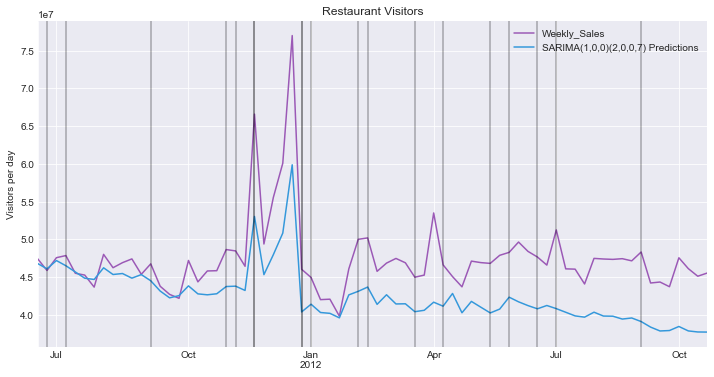

In [61]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['Weekly_Sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for index, row in holidays[(byDate.index[train_len] <= holidays.Date) & (holidays.Date <= byDate.index[length-1])].iterrows():
    holiday = row['Date']
    ax.axvline(x=holiday, c='k', alpha = 0.3)

In [62]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['Weekly_Sales'], predictions)
error2 = rmse(test['Weekly_Sales'], predictions)

print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 3.555339881e+13
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 5962667.089


# SARIMAx
add the exog variable

In [63]:
model = SARIMAX(train['Weekly_Sales'],exog=train['IsHoliday'],order=(2,0,2),seasonal_order=(1,0,0,52),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Weekly_Sales   No. Observations:                   71
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -1263.602
Date:                             Sat, 23 May 2020   AIC                           2541.204
Time:                                     09:42:32   BIC                           2557.042
Sample:                                 02-05-2010   HQIC                          2547.502
                                      - 06-10-2011                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IsHoliday   4.951e+07    3.9e-08   1.27e+15      0.000    4.95e+07    4.95e+07
ar.L1          0.0083      0.365      0.023      0.982      -0.707       0.723
ar.L2          0.9917      0.364      2.726      0.006       0.279       1.705
ma.L1         -0.0057      0.702     -0.008      0.994      -1.382       1.371
ma.L2         -0.9734      0.475     -2.051      0.040      -1.904      -0.043
ar.S.L52       0.5121      0.156      3.277      0.001       0.206       0.818
sigma2      1.739e+14   2.12e-15    8.2e+28      0.000    1.74e+14    1.74e+14
===================================================================================
Ljung-Box (Q):                       26.90   Jarque-Bera (JB):               209.29
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -2.00
Prob(H) (two-sided):                  0.44   Kurtosis:                        10.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.66e+44. Standard errors may be unstable.
"""

In [64]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['IsHoliday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Predictions')

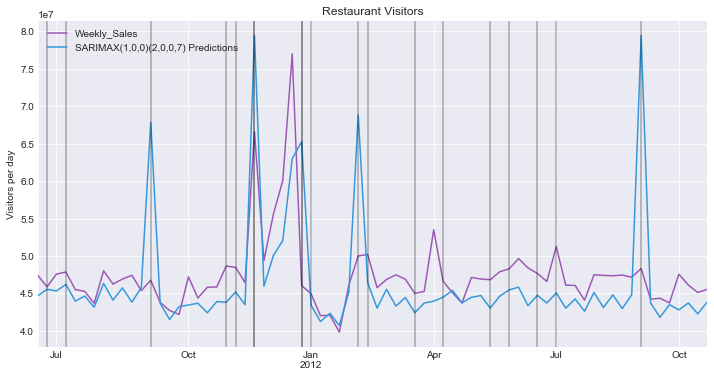

In [65]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['Weekly_Sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for index, row in holidays[(byDate.index[train_len] <= holidays.Date) & (holidays.Date <= byDate.index[length-1])].iterrows():
    holiday = row['Date']
    ax.axvline(x=holiday, c='k', alpha = 0.3)

In [66]:
# Print values from SARIMA above
print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')
print()

error1x = mse(test['Weekly_Sales'], predictions)
error2x = rmse(test['Weekly_Sales'], predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,0)(2,0,0,7) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(2,0,0,7) RMSE Error: {error2x:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 3.555339881e+13
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 5962667.089

SARIMAX(1,0,0)(2,0,0,7) MSE Error: 4.352390593e+13
SARIMAX(1,0,0)(2,0,0,7) RMSE Error: 6597265.034


In [67]:
byDatex = sales.groupby('Date').sum()
byDatex

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,65124,130557,49750740.50,0.0
2010-02-12,65082,131179,48336677.63,2956.0
2010-02-19,65610,131897,48276993.78,0.0
2010-02-26,65045,130161,43968571.13,0.0
2010-03-05,64897,129670,46871470.30,0.0
...,...,...,...,...
2012-09-28,65866,130785,43734899.40,0.0
2012-10-05,66296,132468,47566639.31,0.0
2012-10-12,66453,133371,46128514.25,0.0


In [68]:
byDatex.IsHoliday = byDatex.IsHoliday.astype('bool').astype('int')
byDatex.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,65124,130557,49750740.50,0
2010-02-12,65082,131179,48336677.63,1
2010-02-19,65610,131897,48276993.78,0
2010-02-26,65045,130161,43968571.13,0
2010-03-05,64897,129670,46871470.30,0


In [69]:
#Split the data into train/test setsDatexs = byDatex.index
length = len(byDatex)
train_len = int(length*0.50)

train = byDatex.iloc[:train_len]
test = byDatex.iloc[train_len:]
test

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2011-06-17,65377,131112,47447561.77,0
2011-06-24,65103,129875,45884094.58,0
2011-07-01,65429,129329,47578519.50,0
2011-07-08,65296,129711,47859263.78,0
2011-07-15,65186,129268,45515929.92,0
...,...,...,...,...
2012-09-28,65866,130785,43734899.40,0
2012-10-05,66296,132468,47566639.31,0
2012-10-12,66453,133371,46128514.25,0


In [70]:
model = SARIMAX(train['Weekly_Sales'],exog=train['IsHoliday'],order=(2,0,2),seasonal_order=(1,0,0,52),enforce_invertibility=False)
results = model.fit()
results.summary()

C:\Users\octav\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

C:\Users\octav\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Weekly_Sales   No. Observations:                   71
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -1263.602
Date:                             Sat, 23 May 2020   AIC                           2541.204
Time:                                     09:42:36   BIC                           2557.042
Sample:                                 02-05-2010   HQIC                          2547.502
                                      - 06-10-2011                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IsHoliday   4.951e+07    3.9e-08   1.27e+15      0.000    4.95e+07    4.95e+07
ar.L1          0.0083      0.365      0.023      0.982      -0.707       0.723
ar.L2          0.9917      0.364      2.726      0.006       0.279       1.705
ma.L1         -0.0057      0.702     -0.008      0.994      -1.382       1.371
ma.L2         -0.9734      0.475     -2.051      0.040      -1.904      -0.043
ar.S.L52       0.5121      0.156      3.277      0.001       0.206       0.818
sigma2      1.739e+14   2.12e-15    8.2e+28      0.000    1.74e+14    1.74e+14
===================================================================================
Ljung-Box (Q):                       26.90   Jarque-Bera (JB):               209.29
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -2.00
Prob(H) (two-sided):                  0.44   Kurtosis:                        10.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.66e+44. Standard errors may be unstable.
"""

In [71]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['IsHoliday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Predictions')

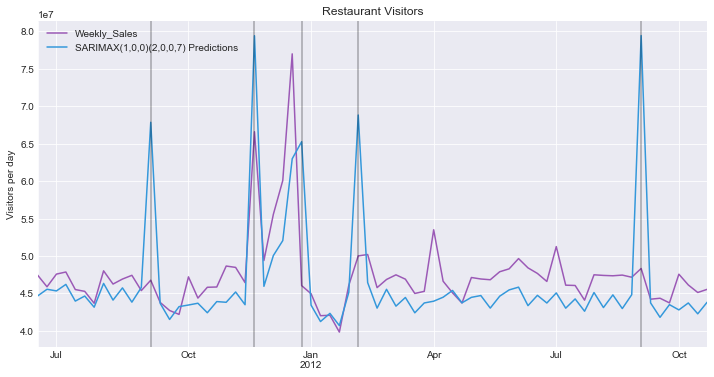

In [72]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['Weekly_Sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query("IsHoliday==1").index:
    ax.axvline(x=x, c='k', alpha = 0.3)

original data only include...incorporate all US consumer spending event (super bowl, black friday) and other commonly observed holdays that would drive consumer spending...assuming all us stores!!!!
back to school...no exact date???

SOME HOLIDAYS HAVE TRAILING SALES (PREPARE)...SOME SAME DAY...